# Chapter 4 - Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

/Users/collinprather/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [157]:
default = pd.read_excel('Data/Default.xlsx')

In [158]:
default['default2'] = default.default.factorize()[0]
default['student2'] = default.student.factorize()[0]
default.head()

,default,student,balance,income,default2,student2
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0
4,No,No,529.250605,35704.493935,0,0
5,No,No,785.655883,38463.495879,0,0


## 4.3 Simple Logistic Regression

$$Pr(y=1|X)=\frac{e^{\beta_0 + \beta_1X}}{1+e^{\beta_0 + \beta_1X}}$$

#### Scikit-Learn

In [159]:
# Let's use balance as our predictor
X_balance = default.balance.values.reshape(-1,1)
y = default.default2

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_balance, y)
print('classes:', clf.classes_)
print('coefficient:', clf.coef_)
print('intercept term:', clf.intercept_)

classes: [0 1]
coefficient: [[ 0.00549891]]
intercept term: [-10.65131887]


#### Statsmodel

In [160]:
X_balance= sm.add_constant(default.balance)    # added column of 1's in order to account for the intercept term
est = smf.Logit(y.ravel(), X_balance).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.6513,0.361,-29.491,0.000,-11.359,-9.943
balance,0.0055,0.000,24.952,0.000,0.005,0.006


Now, with this model, we can estimate the probabilty that someone will default on their credit card, given their card balance. We just need to plug in our coefficients into the sigmoid (logistic) function along with their bank balance. Let's assume their balance is $1000. 

In [161]:
# est.params[0] is the intercept term derived from our model above, -10.6513
# est.params[1] is the slope term derived from our model above, 0.0055
prob_default = (np.exp(est.params[0]+est.params[1]*1000)) / (1 + (np.exp(est.params[0]+est.params[1]*1000)))
prob_default

0.0057521450680737569

We can interpret this as a .6% chance that they will default on their credit card. However, if their card balance is $2000, the estimated probability that they'll default rises to 59% as shown below.

In [162]:
prob_default = (np.exp(est.params[0]+est.params[1]*2000)) / (1 + (np.exp(est.params[0]+est.params[1]*2000)))
prob_default

0.58576936983133143

In [163]:
prob_default = (np.exp(est.params[0]+est.params[1]*1937)) / (1 + (np.exp(est.params[0]+est.params[1]*1937)))
prob_default

0.50001787048806834

---

In [164]:
X_student = sm.add_constant(default.student2)
est = smf.Logit(y.ravel(), X_student).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,coef,std err,z,P>|z|,[0.025,0.975]
const,-3.5041,0.071,-49.554,0.000,-3.643,-3.366
student2,0.4049,0.115,3.520,0.000,0.179,0.630


In [165]:
prob_default_student = (np.exp(est.params[0]+est.params[1]*1)) / (1 + (np.exp(est.params[0]+est.params[1]*1)))
prob_default_not_student = (np.exp(est.params[0]+est.params[1]*0)) / (1 + (np.exp(est.params[0]+est.params[1]*0)))
print(prob_default_student)
print(prob_default_not_student)

0.0431385869565
0.0291950113379


As shown by the p-values above, whether or not the card-holder is a student is a significant predictor of whether or not they'll default as well. In fact, if they're a student we estimate that their chances of defaulting double!

### Multivariate Logistic Regression

$$Pr(y=1|X)=\frac{e^{\beta_0 + \beta_1X_1+\dots+\beta_pX_p}}{1+e^{\beta_0 + \beta_1X_1+\dots+\beta_pX_p}}$$

#### Scikit-Learn

In [166]:
X = default[['balance', 'income', 'student2']]
y = default.default2

# Notice that these coefficients are different than those output by Statsmodel below. When I use the 'newton-cg' solver,
# I achieve the same coefficients, but am warned that the algorithm does not converge. Not sure how to interpret this.
clf = skl_lm.LogisticRegression()
clf.fit(X, y)
print('classes:', clf.classes_)
print('coefficient:', clf.coef_)
print('intercept term:', clf.intercept_)

classes: [0 1]
coefficient: [[  4.07583928e-04  -1.25881515e-04  -2.51031353e-06]]
intercept term: [ -1.94179681e-06]


#### Statsmodel

In [167]:
X = sm.add_constant(default[['balance', 'income', 'student2']])
y = default.default2
est = smf.Logit(y.ravel(), X).fit()
est.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.8690,0.492,-22.079,0.000,-11.834,-9.904
balance,0.0057,0.000,24.737,0.000,0.005,0.006
income,3.033e-06,8.2e-06,0.370,0.712,-1.3e-05,1.91e-05
student2,-0.6468,0.236,-2.738,0.006,-1.110,-0.184


---

In [168]:
b0 = -6
b1 = .05
b2 = 1
x1 = 50
x2 = 3.5

coeffs = np.array([b0, b1, b2])
data = np.array([1, x1, x2])
linear_equation = np.dot(coeffs, data)
        
prob_a = (np.exp(linear_equation)) / (1 + (np.exp(linear_equation)))
prob_a

0.5

---

## 4.4 Linear Discriminant Analysis

Linear Discriminant Analysis is a different approach to classification. Here, we'll (most often) use a normal distribution  to model the distribution of X in each of the separate classes, then use Bayes theorem to flip things around and obtain PR$(Y|X)$.
Bayes theorem states that:
$$PR(Y=y|X=x)=\frac{PR(X=x|Y=k) \cdot PR(Y=k)}{PR(X=x)}$$
Adapted for discriminant analysis, it is general convention to write this equation like so:
$$PR(Y=y|X=x)= \frac{\pi_k\cdot f_k(x)}{\sum_{i=1}^{k}\pi_if_i(x)}$$,
where
* $f_k(x)$=Pr$(X=x|Y=k)$ is the density for X in class $k$. We use normal densities for these, separately in each class.
* $\pi_k=$ Pr$(Y=k)$ is the marginal or prior probability for class $k$. ( $\frac{\text{num observations in class k}}{\text{total num of observations}}$)

We then classify new datapoints $x$ to the class with the highest density, given $X$. In other words, we assign $X$ to a class based on which class the probability: $PR(Y=y|X=x)$ is the largest. This is equivalent to assigning $x$ to the class with the largest discriminant score, $\delta_k$:
$$\delta_k(x)=x\cdot \frac{\mu_k}{\sigma^2}-\frac{\mu^2_k}{2\sigma^2}+\log(\pi_k)$$
Note that $\delta_k(x)$ is a linear function, which is what makes this "linear" discriminant analysis.

In [169]:
%%latex
The last step is to estimate our parameters $\hat{\ \pi}_k$, $\hat{\ \mu}_k$, and $\hat{\ \sigma^2}$.
\begin{align*}
	\hat{\pi_k}&= \frac{n_k}{n}\\
	\hat{\mu_k}&=\frac{1}{n_k}\sum_{i:y_i=k}x_i\\
	\hat{\sigma^2}&=\frac{1}{n-K}\sum_{k=1}^{K}\sum_{i:y_i=k}(x_i-\hat{\mu_k})^2\\
	&= \sum_{k=1}^{k}=\frac{n_k-1}{n-K}\cdot\hat{\sigma^2}_k
\end{align*}

<IPython.core.display.Latex object>

In [170]:
# another look at the data
default.head()

,default,student,balance,income,default2,student2
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0
4,No,No,529.250605,35704.493935,0,0
5,No,No,785.655883,38463.495879,0,0


#### Scikit-Learn

In [171]:
X = default[['balance', 'income', 'student2']].as_matrix()
y = default.default2.as_matrix()

lda = LinearDiscriminantAnalysis(solver='svd')
clf = lda.fit(X,y)
y_score = clf.decision_function(X)

In [172]:
y_pred = clf.predict(X)
print(classification_report(y, y_pred, target_names=['No', 'Yes']))

             precision    recall  f1-score   support

         No       0.97      1.00      0.99      9667
        Yes       0.78      0.24      0.36       333

avg / total       0.97      0.97      0.97     10000



In [173]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)

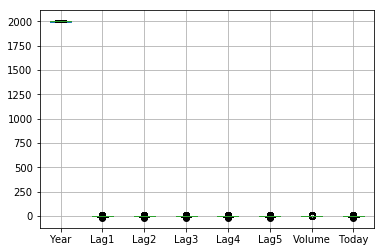

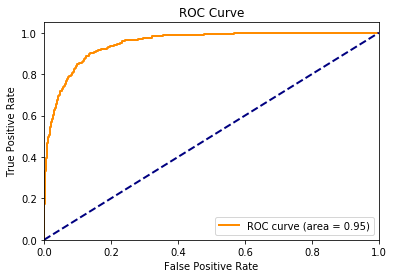

In [174]:
# Plotting the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

---

#### Quick Comparison of Logistic Regression and Linear Discriminant Analysis

It can be show mathematically that in a two class classification problem, Logistic Regression and LDA take the same form. Where they differ is in how the parameters are estimated. 
* Logistic REgression uses the conditional likelihood based on $Pr(Y|X)$ (known as discriminative learning)
* LDA uses the full likelihood based on $PR(X|Y)$ (known as generative learning)

---

## Labs

### 4.6.2 Linear Discriminant Analysis

In [176]:
smarket = pd.read_csv('Data/Smarket.csv', usecols=range(1,10), index_col=0, parse_dates=True)
smarket.head()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
Year,,,,,,,,
2001-01-01,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2001-01-01,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2001-01-01,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
2001-01-01,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
2001-01-01,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [177]:
X_train = smarket[:'2004'][['Lag1', 'Lag2']]
y_train = smarket[:'2004']['Direction']

X_test = smarket['2005':][['Lag1', 'Lag2']]
y_test = smarket['2005':]['Direction']

In [178]:
lda = LinearDiscriminantAnalysis()
pred = lda.fit(X_train, y_train).predict(X_test)

In [179]:
lda.priors_

array([ 0.49198397,  0.50801603])

In [180]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [181]:
lda.coef_

array([[-0.05544078, -0.0443452 ]])

In [182]:
confusion_matrix(y_test, pred).T

array([[ 35,  35],
       [ 76, 106]])

In [183]:
print(classification_report(y_test, pred, digits=3))

             precision    recall  f1-score   support

       Down      0.500     0.315     0.387       111
         Up      0.582     0.752     0.656       141

avg / total      0.546     0.560     0.538       252



In [184]:
pred_p = lda.predict_proba(X_test)
np.unique(pred_p[:,1]>0.5, return_counts=True)

(array([False,  True], dtype=bool), array([ 70, 182]))

We can interpret the array printed above as stating that in 2005, there were 70 days that our model predicted there was a greater than 50% chance that the stock market would go up and 182 days that our model predicted there was a less than 50% chance that the stock market would go up.

### 4.6.4 Quadratic Discriminant Analysis

In [185]:
qda = QuadraticDiscriminantAnalysis()
q_pred = qda.fit(X_train, y_train).predict(X_test)

In [186]:
qda.priors_

array([ 0.49198397,  0.50801603])

In [187]:
qda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [188]:
confusion_matrix(y_test, q_pred).T

array([[ 30,  20],
       [ 81, 121]])

In [189]:
print(classification_report(y_test, q_pred, digits=3))

             precision    recall  f1-score   support

       Down      0.600     0.270     0.373       111
         Up      0.599     0.858     0.706       141

avg / total      0.599     0.599     0.559       252



Our QDA predictions accurately predict whether the stock market will go up or down 59.9% of the time in 2005.

### 4.6.6 An Application to Caravan Insurance Data

In [192]:
caravan = pd.read_csv('Caravan.csv', index_col=0)
y = caravan.Purchase
X = caravan.drop('Purchase', axis=1).astype('float64')
X_scaled = preprocessing.scale(X)

In [193]:
X_train = X_scaled[1000:]
y_train = y[1000:]

X_test = X_scaled[:1000]
y_test = y[:1000]

In [194]:
clf = neighbors.KNeighborsClassifier(n_neighbors=1, weights='uniform')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = clf.score(X_test, y_test)

In [195]:
score

0.88200000000000001

With $k=1$, we correctly predict whether or not the customer will buy a caravan 88.2% of the time. This sounds like a fairly accurate classifier, except for the fact that we could make predictions with 94% accuracy..
Let's try adjusting the 'n_neighbors' parameter. I'll create a function to change this parameter easily.

In [196]:
def knn(n_neighbors=1, weight='uniform'):
    clf = neighbors.KNeighborsClassifier(n_neighbors)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print(score)
    cm_df = pd.DataFrame(confusion_matrix(y_test, pred).T, index=clf.classes_, columns=clf.classes_)
    print(cm_df)
    return pred

In [197]:
k1 = knn(1)

0.882
      No  Yes
No   873   50
Yes   68    9


In [198]:
k3 = knn(3)

0.926
      No  Yes
No   921   54
Yes   20    5


In [199]:
k5 = knn(5)

0.934
      No  Yes
No   930   55
Yes   11    4


In [200]:
k10 = knn(10) # with k=10, our classifier guesses no everytime

0.941
      No  Yes
No   941   59
Yes    0    0
